In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
from torchvision.datasets.utils import download_url


# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
    
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

  0%|          | 0/135107811 [00:00<?, ?it/s]

['test', 'train']
['automobile', 'bird', 'frog', 'horse', 'dog', 'ship', 'cat', 'deer', 'airplane', 'truck']


In [ ]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # Used for Data Normalising 
# 1st Bracket of values are the Mean Values of R,G,B and the 2nd Bracket of values are the Std. Deviations of R,G,B
# These Values of Mean & Std. Deviation and useful as we saw that during Channel Normalisation we need the Mean & Std. Deviation to Normalise the Channel-wise Data
# 'tt' stands for " import torchvision.transforms as tt "
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), # '32' stands for how many pixels we want to crop to, but already data is 32x32, so we add a padding i.e 0 padding i.e black 0 padding of 4 so 32x32->40x40 as both top-bottom & left-right we have pixels. Then we set a padding_mode.
                                                                               # So, after the padding the image is shifted by upto 4 pixels each time towards any side and then we take the 32x32 pixel crop image 
                         tt.RandomHorizontalFlip(), # Applies with a probability of 0.5
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),

                    # Above are the Data Augmentation
                         tt.ToTensor(), # We apply this after the Images are Transformed and then we do the ToTensor to convert them into a Tensor
                         tt.Normalize(*stats,inplace=True)]) # Now Normalizing is done by taking those 'stats' from the top to get a Normal Distribution
# The Compose Operation is used to combine the multiple Tranformations
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)]) # Only ToTensor() & Normalize(*stats)
# On Validation dataset we do NOT apply Data Augmentation Transformations as it is used to report the performance of the model

In [ ]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [ ]:
batch_size = 400

In [ ]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


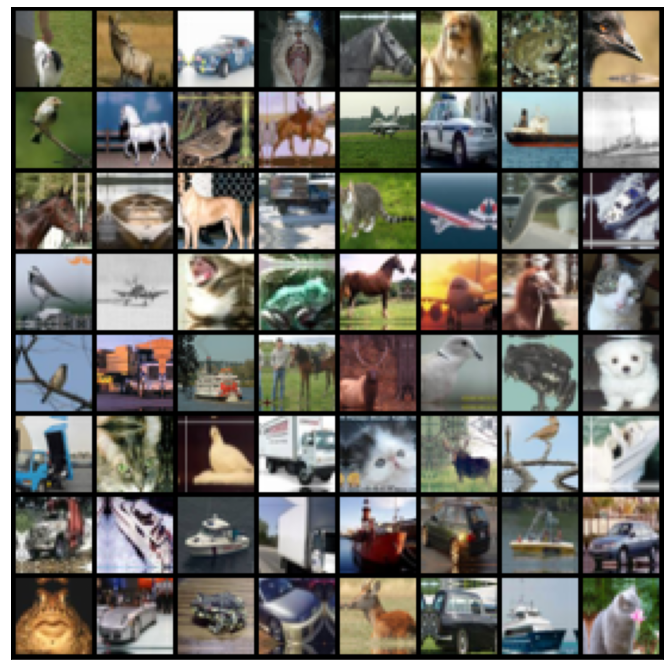

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # I/P -> 3x32x32
        self.conv1 = conv_block(in_channels, 64) # O/P -> 64x32x32
        self.conv2 = conv_block(64, 128, pool=True) # O/P -> 128x16x16 as Pool=True
        self.res1 = nn.Sequential(conv_block(128, 128),
                                  conv_block(128, 128)) # Basically connects the 2 Convolutional Blocks as the 1st Residual Layer Block
                                                        # Remember that in Residual Blocks we have same O/P Channels i.e Constant
                                                        # O/P -> 128x16x16 is Retained after the Residual Layer Block
        self.conv3 = conv_block(128, 256, pool=True) # O/P -> 256x8x8 as Pool=True
        self.conv4 = conv_block(256, 512, pool=True) # O/P -> 512x4x4 as Pool=True
        self.res2 = nn.Sequential(conv_block(512, 512),
                                  conv_block(512, 512))# Basically connects the 2 Convolutional Blocks as the 1st Residual Layer Block
                                                        # Remember that in Residual Blocks we have same O/P Channels i.e Constant
                                                        # O/P -> 512x4x4 is Retained after the Residual Layer Block
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), # Here we take 4x4 MaxPool2d to get 512x1x1 instead of 2x2 MaxPool2d which would have given 512x2x2
                                        nn.Flatten(),  # Flattens 512x1x1 to give 512
                                        nn.Dropout(0.2), # To avoid Overfitting we randomly take 20% (default=50%) of the feature maps from the previous layer and set to 0.
                                        nn.Linear(512, num_classes)) # Takes the Flatten I/P of 512 I/Ps and makes a Linear Layer 10 Classes 
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out # Residual is added back to this O/P
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out # Residual is added back to this O/P
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, 10), device) # 3 I/P Channels & 10 O/P Channels as a Whole
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step() # For every batch different learning rate will be updated
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.09701923280954361, 'val_loss': 2.302182674407959}]

In [ ]:
epochs = 40
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00138, train_loss: 1.4818, val_loss: 1.2079, val_acc: 0.5939
Epoch [1], last_lr: 0.00394, train_loss: 0.9943, val_loss: 1.4249, val_acc: 0.5912
Epoch [2], last_lr: 0.00703, train_loss: 0.8804, val_loss: 1.4238, val_acc: 0.5816
Epoch [3], last_lr: 0.00935, train_loss: 0.7588, val_loss: 1.4280, val_acc: 0.5618
Epoch [4], last_lr: 0.00999, train_loss: 0.6373, val_loss: 1.1865, val_acc: 0.6437
Epoch [5], last_lr: 0.00972, train_loss: 0.5329, val_loss: 0.8853, val_acc: 0.7163
Epoch [6], last_lr: 0.00908, train_loss: 0.4857, val_loss: 0.7197, val_acc: 0.7634
Epoch [7], last_lr: 0.00812, train_loss: 0.4356, val_loss: 0.8293, val_acc: 0.7482
Epoch [8], last_lr: 0.00691, train_loss: 0.3849, val_loss: 0.5201, val_acc: 0.8207
Epoch [9], last_lr: 0.00556, train_loss: 0.3469, val_loss: 0.4722, val_acc: 0.8400
Epoch [10], last_lr: 0.00416, train_loss: 0.3098, val_loss: 0.4297, val_acc: 0.8534
Epoch [11], last_lr: 0.00283, train_loss: 0.2496, val_loss: 0.4158, val_acc: 0.8653
Ep

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

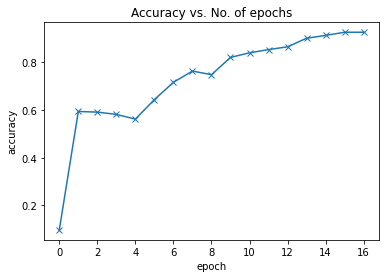

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

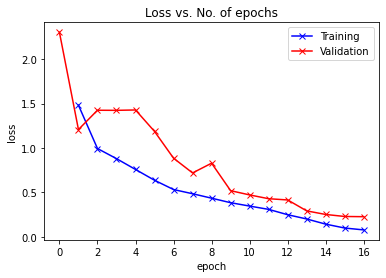

In [ ]:
plot_losses(history)